In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.calibration import CalibrationDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from comet_ml import Experiment
import joblib
import os

In [2]:
# Load the data from the csv file
def load_data(path):
    data = pd.read_csv(path)
    return data

In [3]:
# Preprocess the data to get the required features only
def preprocess_data(data):
    # Drop period_time 
    data = data.drop(['period_time'], axis=1)
    # Use one hot encoding to convert the categorical variables to numerical
    data = pd.get_dummies(data, columns=['secondary_type','last_event_type'], drop_first=True)
    return data

In [4]:
def plot_roc_curve(model,x_val,y_val,title):
    y_pred_proba = model.predict_proba(x_val)[:,1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=title+'(area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    # plt.savefig('Log_ROC')
    plt.show()

# Shot probability model percentile based on distance and angle
def shot_probability(model, x_val):
    model_prob = model.predict_proba(x_val)[:,1]
    x_axis = np.arange(len(model_prob))[::-1]*100/len(model_prob)
    y_axis = np.sort(model_prob)[::-1]
    plt.plot(x_axis, y_axis)
    plt.xlabel('Shot probability model percentile')
    plt.ylabel('Goal Rate')
    plt.title('Shot probability model percentile based on distance and angle')
    plt.show()

def cumulative_probability(model, x_val):
    model_prob = model.predict_proba(x_val)[:,1]
    x_axis = np.arange(len(model_prob))[::-1]*100/len(model_prob)
    y_axis = np.sort(model_prob)[::-1]
    y_axis_cum = np.cumsum(y_axis)/np.sum(y_axis)
    plt.plot(x_axis, y_axis_cum)
    plt.xlabel('Shot Probability Model Percentile')
    plt.ylabel('Cumulative proportion of goals')
    plt.title('Cumulative probability of goals')
    plt.show()

# Calibration plot using CalibrationDisplay
def calibration_plot(model, x_val, y_val, title):
    CalibrationDisplay.from_estimator(model, x_val, y_val, n_bins=10, name=title, ax=None)
    plt.title('Reliability Diagram')
    plt.show()

In [5]:
# Splitting the dataset into the Training set and Test set for grid search CV 5
#preprocess
def split_data(data):
    X = data.drop(['goal'], axis=1)
    y = data['goal']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
    return X_train, X_test, y_train, y_test

In [6]:
def random_forest_classifier(X_train, y_train, X_test, y_test):
    # Create a random forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

    # Train the classifier
    clf.fit(X_train, y_train)

    # Print the name and gini importance of each feature
    for feature in zip(X_train.columns, clf.feature_importances_):
        print(feature)

    # Plot the feature importance
    plt.figure(figsize=(10,10))
    feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(20).plot(kind='barh')
    plt.show()

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)

    # Calculate the AUC
    auc = roc_auc_score(y_test, y_pred)
    print('AUC: ', auc)
    
    # Calculate the precision
    precision = precision_score(y_test, y_pred)
    print('Precision: ', precision)

    # Calculate the recall
    recall = recall_score(y_test, y_pred)
    print('Recall: ', recall)

    # Calculate the f1 score
    f1 = f1_score(y_test, y_pred)
    print('F1 score: ', f1)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    #Classification report
    report = classification_report(y_test, y_pred)
    print(report)

    # Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    return clf, accuracy, auc, cm, report, precision, recall, f1


In [7]:
# Hyper parameter tuning for random forest classifier
def random_forest_tuned(X_train,y_train,X_test,y_test):
    # Create a random forest classifier
    clf = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=100, max_depth=10, max_features='auto')

    # Create a pipeline
    pipe = Pipeline(steps=[('pca', PCA()), ('clf', clf)])

    # Fit the model
    pipe.fit(X_train, y_train)

    # Predict the test set
    y_pred = pipe.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)

    # Calculate the AUC
    auc = roc_auc_score(y_test, y_pred)
    print('AUC: ', auc)
    
    # Calculate the precision
    precision = precision_score(y_test, y_pred)
    print('Precision: ', precision)

    # Calculate the recall
    recall = recall_score(y_test, y_pred)
    print('Recall: ', recall)

    # Calculate the f1 score
    f1 = f1_score(y_test, y_pred)
    print('F1 score: ', f1)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    #Classification report
    report = classification_report(y_test, y_pred)
    print(report)

    # Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    return pipe, accuracy, auc, cm, report, precision, recall, f1

##### Decision Trees

In [8]:
def decision_tree_model(X_train,y_train,X_test,y_test):
    tree_clas = DecisionTreeClassifier()
    tree_clas.fit(X_train, y_train)
    y_pred = tree_clas.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)

    auc = roc_auc_score(y_test, y_pred)
    print('AUC: ', auc)

    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Calculate the precision
    precision = precision_score(y_test, y_pred)
    print('Precision: ', precision)

    # Calculate the recall
    recall = recall_score(y_test, y_pred)
    print('Recall: ', recall)

    # Calculate the f1 score
    f1 = f1_score(y_test, y_pred)
    print('F1 score: ', f1)

    # Plot the confusion matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()
    
    #Classification report
    report = classification_report(y_test, y_pred)
    print(report)

    # Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    return tree_clas, accuracy, auc, cm, report, precision, recall, f1

In [9]:
def decision_tree_tuned(X_train,y_train,X_test,y_test):
    param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
                  'ccp_alpha': [0.000000001, 0.0000001, 0.1, .001],
                  'criterion' :['gini', 'entropy']
                 }
    tree_clas = DecisionTreeClassifier(random_state=1024)
    grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=3, verbose=True)
    grid_search.fit(X_train, y_train)
    final_model = grid_search.best_estimator_
    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)

    auc = roc_auc_score(y_test, y_pred)
    print('AUC: ', auc)

    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Calculate the precision
    precision = precision_score(y_test, y_pred)
    print('Precision: ', precision)

    # Calculate the recall
    recall = recall_score(y_test, y_pred)
    print('Recall: ', recall)

    # Calculate the f1 score
    f1 = f1_score(y_test, y_pred)
    print('F1 score: ', f1)

    # Plot the confusion matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

    #Classification report
    report = classification_report(y_test, y_pred)
    print(report)

    # Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    return final_model, accuracy, auc, cm, report, precision, recall, f1
    

K-Nearest Neighbours

In [10]:
def knn_classifier(X_train,y_train,X_test,y_test):
    knn = KNeighborsClassifier()
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)

    auc = roc_auc_score(y_test, y_pred)
    print('AUC: ', auc)

    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Calculate the precision
    precision = precision_score(y_test, y_pred)
    print('Precision: ', precision)

    # Calculate the recall
    recall = recall_score(y_test, y_pred)
    print('Recall: ', recall)

    # Calculate the f1 score
    f1 = f1_score(y_test, y_pred)
    print('F1 score: ', f1)

    # Plot the confusion matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()
    
    #Classification report
    report = classification_report(y_test, y_pred)
    print(report)

    # Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    return knn, accuracy, auc, cm, report, precision, recall, f1

##### MLP

In [11]:
def mlp_classifier(X_train, y_train, X_test, y_test):
    mlp = MLPClassifier(random_state=0, max_iter=1000, hidden_layer_sizes=(100,100,100), activation='relu', solver='adam')
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)
    
    auc = roc_auc_score(y_test, y_pred)
    print('AUC: ', auc)

    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Calculate the precision
    precision = precision_score(y_test, y_pred)
    print('Precision: ', precision)

    # Calculate the recall
    recall = recall_score(y_test, y_pred)
    print('Recall: ', recall)

    # Calculate the f1 score
    f1 = f1_score(y_test, y_pred)
    print('F1 score: ', f1)

    # Plot the confusion matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()
    
    #Classification report
    report = classification_report(y_test, y_pred)
    print(report)

    # Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    return mlp, accuracy, auc, cm, report, precision, recall, f1


In [12]:
def mlp_classifier_tuned(X_train, y_train, X_test, y_test):
    clf = MLPClassifier(random_state=0, max_iter=1000, hidden_layer_sizes=(100,100,100), activation='relu', solver='adam')
    pipe = Pipeline(steps=[('pca', PCA()), ('clf', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    # Confusion matrix
    # Display confusion matrix as a plot
    # TypeError: confusion_matrix() missing 1 required positional argument: 'y_val'
    # Solution to this error is to pass y_test and y_pred as parameters
    
    
    auc = roc_auc_score(y_test, y_pred)
    print('AUC: ', auc)

    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Calculate the precision
    precision = precision_score(y_test, y_pred)
    print('Precision: ', precision)

    # Calculate the recall
    recall = recall_score(y_test, y_pred)
    print('Recall: ', recall)

    # Calculate the f1 score
    f1 = f1_score(y_test, y_pred)
    print('F1 score: ', f1)

    # Plot the confusion matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()
    
    #Classification report
    report = classification_report(y_test, y_pred)
    print(report)

    # Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    return pipe, accuracy, auc, cm, report, precision, recall, f1



In [13]:
def mlp_classifier_randCV(X_train, y_train, X_test, y_test):
    clf = MLPClassifier(random_state=0, max_iter=10, hidden_layer_sizes=(100,100,100), activation='relu', solver='adam')
    pipe = Pipeline(steps=[('pca', PCA()), ('clf', clf)])

    # Create a dictionary of hyperparameters
    param_grid = {
        'clf__hidden_layer_sizes': [ (100,100), (100,)],
        'clf__activation': ['relu', 'tanh', 'logistic'],
        'clf__solver': ['adam', 'sgd', 'lbfgs'],
        'clf__alpha': [0.0001, 0.05],
        'clf__learning_rate': ['constant','adaptive'],
    }

    # Create a randomized search cross validation
    random_search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=3, cv=5, random_state=0)
    random_search.fit(X_train, y_train)
    y_pred = random_search.predict(X_test)

    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)

    # Confusion matrix
    # Display confusion matrix as a plot
    # TypeError: confusion_matrix() missing 1 required positional argument: 'y_val'
    # Solution to this error is to pass y_test and y_pred as parameters
    
    auc = roc_auc_score(y_test, y_pred)
    print('AUC: ', auc)

    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Calculate the precision
    precision = precision_score(y_test, y_pred)
    print('Precision: ', precision)

    # Calculate the recall
    recall = recall_score(y_test, y_pred)
    print('Recall: ', recall)

    # Calculate the f1 score
    f1 = f1_score(y_test, y_pred)
    print('F1 score: ', f1)

    # Plot the confusion matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()
    
    #Classification report
    report = classification_report(y_test, y_pred)
    print(report)

    # Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    return random_search, accuracy, auc, cm, report, precision, recall, f1

('game_id', 0.08450114304714454)
('period', 0.03143599293394188)
('coordinates_x', 0.0718253115877005)
('coordinates_y', 0.06928387810609064)
('shot_distance', 0.10987509099088485)
('shot_angle', 0.08967976068952417)
('last_event_coordinates_x', 0.07813385774852864)
('last_event_coordinates_y', 0.0765253295528032)
('time_from_last_event(s)', 0.07371469079411808)
('distance_from_last_event', 0.0993065126312397)
('rebound', 0.0037503127763045406)
('angle_change', 0.030704918840980314)
('speed', 0.10946170842770232)
('secondary_type_Deflected', 0.0035873767758252046)
('secondary_type_Slap Shot', 0.005868052349095139)
('secondary_type_Snap Shot', 0.007915069830637668)
('secondary_type_Tip-In', 0.0055377214900923745)
('secondary_type_Wrap-around', 0.0012770636938897115)
('secondary_type_Wrist Shot', 0.011458718011555912)
('last_event_type_Faceoff', 0.006353437165596817)
('last_event_type_Giveaway', 0.006405421219378006)
('last_event_type_Goal', 0.00024074339114083413)
('last_event_type_Hit'

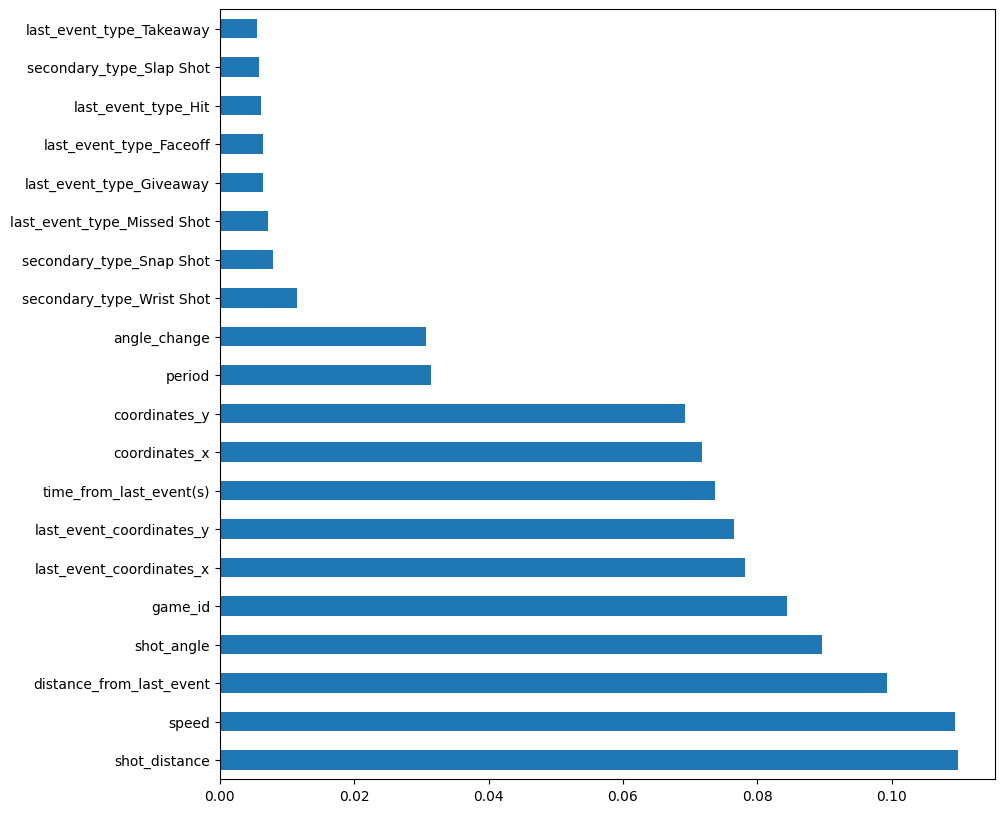

Accuracy:  0.9052344209769175
AUC:  0.5097637564815254
Precision:  0.43478260869565216
Recall:  0.022577283779089963
F1 score:  0.042925540696714545


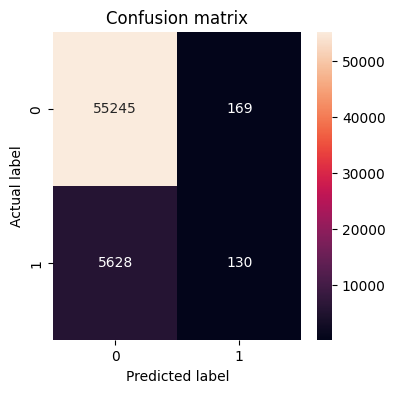

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     55414
           1       0.43      0.02      0.04      5758

    accuracy                           0.91     61172
   macro avg       0.67      0.51      0.50     61172
weighted avg       0.86      0.91      0.86     61172



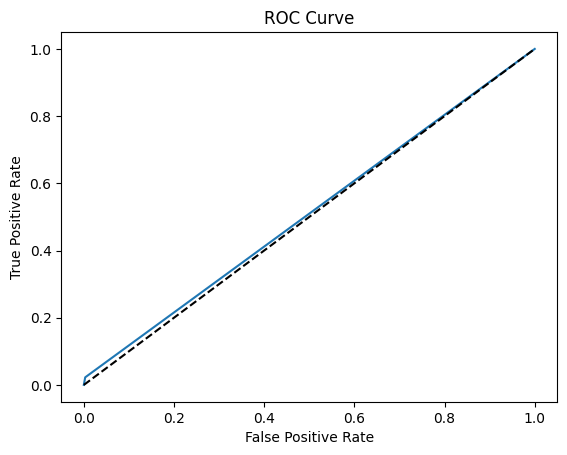

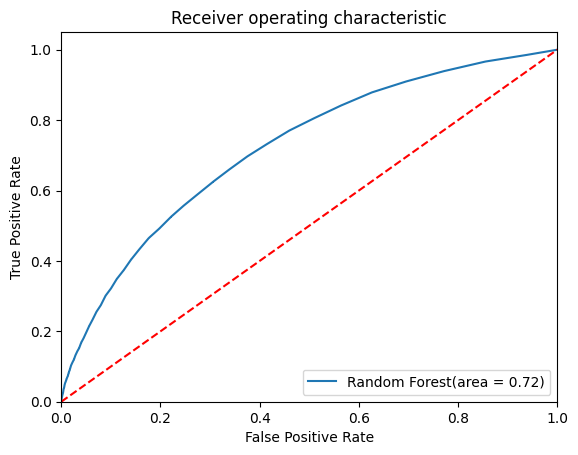

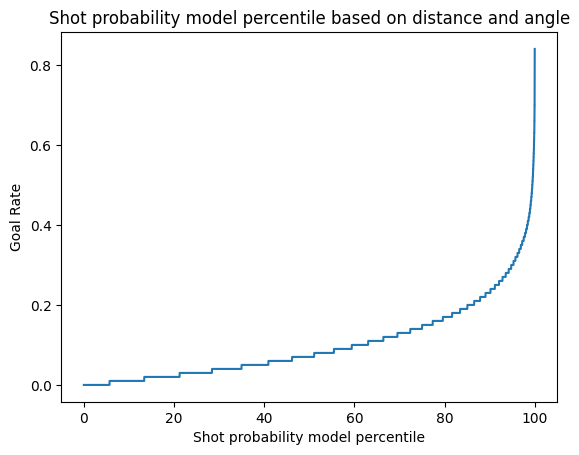

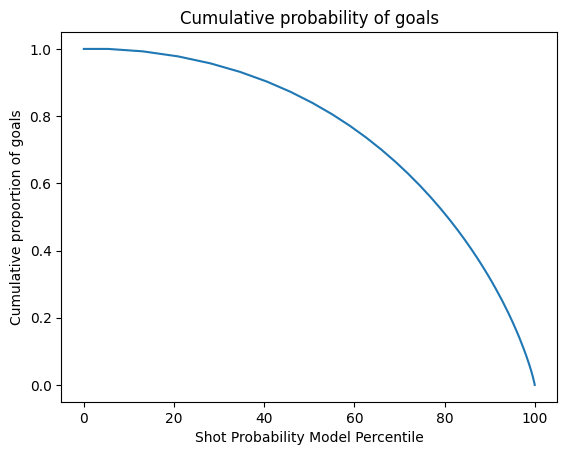

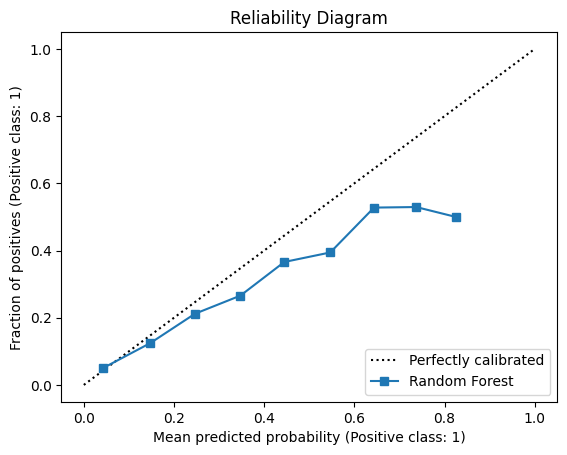

In [14]:
df = load_data('D:/NHLPro/data/M2_added_features_all.csv')
df.head()
df = preprocess_data(df)
X_train, X_test, y_train, y_test = split_data(df)

model1, accuracy, auc, cm, report, precision, recall, f1 = random_forest_classifier(X_train, y_train, X_test, y_test)
plot_roc_curve(model1, X_test, y_test, "Random Forest")
shot_probability(model1, X_test)
cumulative_probability(model1, X_test)
calibration_plot(model1, X_test, y_test, "Random Forest")

C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy:  0.9058883149153207
AUC:  0.5025768426272477
Precision:  0.5076923076923077
Recall:  0.005731156651615144
F1 score:  0.011334363730036063


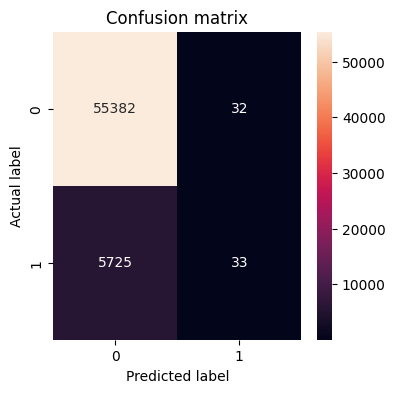

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     55414
           1       0.51      0.01      0.01      5758

    accuracy                           0.91     61172
   macro avg       0.71      0.50      0.48     61172
weighted avg       0.87      0.91      0.86     61172



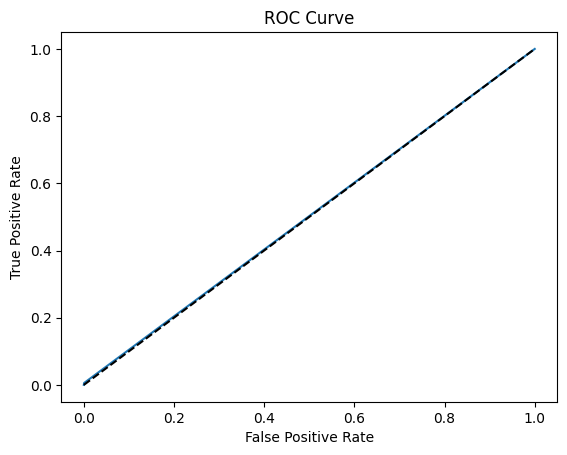

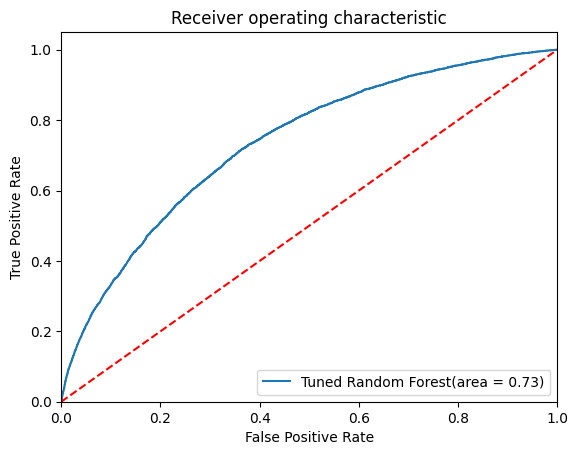

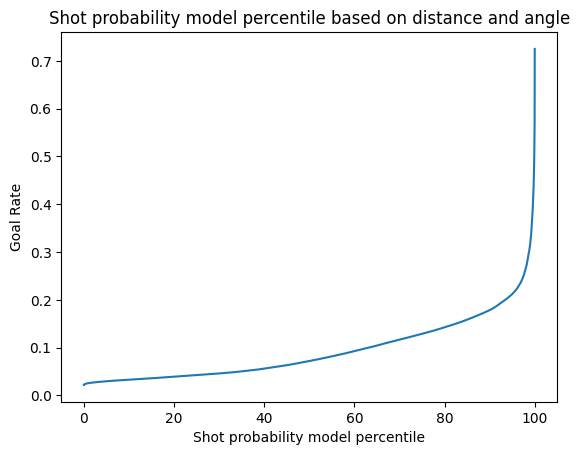

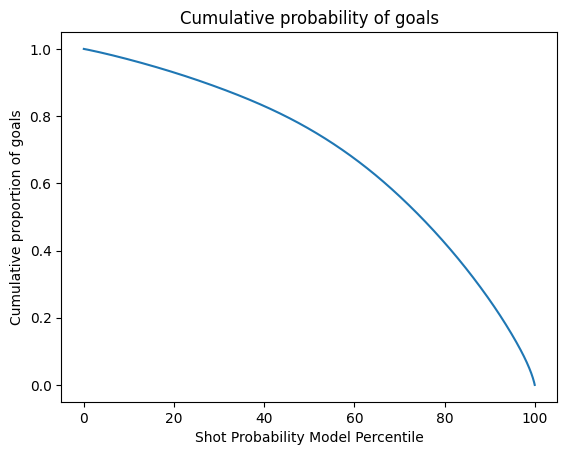

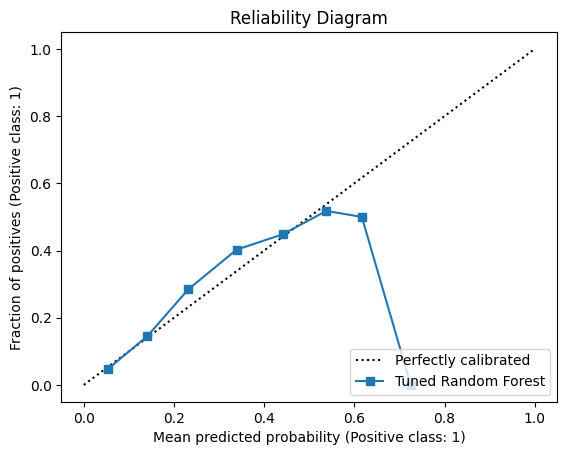

In [15]:
model2, accuracy2, auc2, cm2, report2, precision2, recall2, f1_2 = random_forest_tuned(X_train,y_train,X_test,y_test)
plot_roc_curve(model2, X_test, y_test, "Tuned Random Forest")
shot_probability(model2, X_test)
cumulative_probability(model2, X_test)
calibration_plot(model2, X_test, y_test, "Tuned Random Forest")

Accuracy:  0.8333387824494867
AUC:  0.5443139752252686
[[49893  5521]
 [ 4674  1084]]
Precision:  0.16411809235427707
Recall:  0.18825981243487322
F1 score:  0.1753619671600744


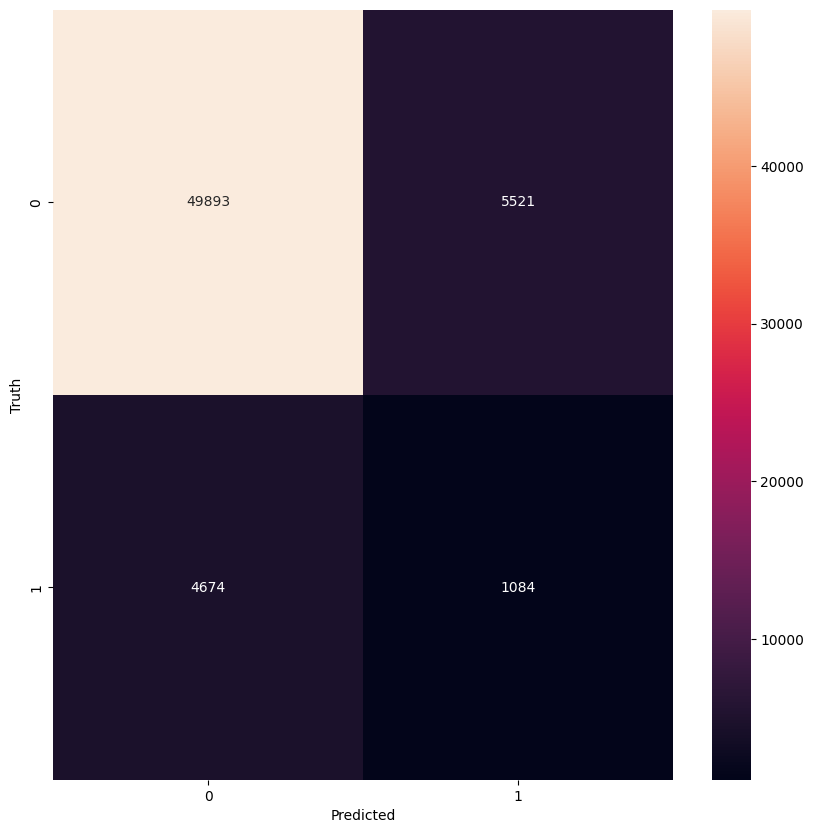

              precision    recall  f1-score   support

           0       0.91      0.90      0.91     55414
           1       0.16      0.19      0.18      5758

    accuracy                           0.83     61172
   macro avg       0.54      0.54      0.54     61172
weighted avg       0.84      0.83      0.84     61172



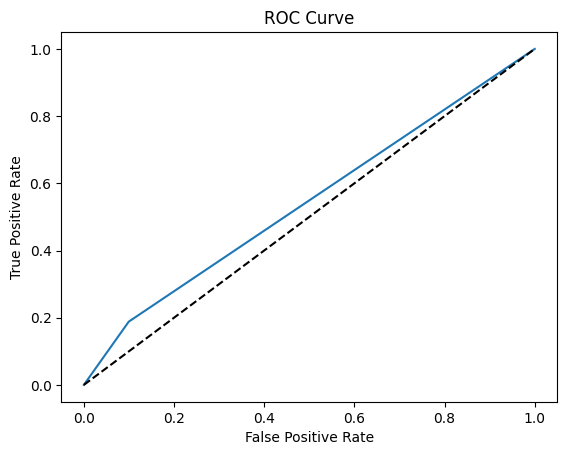

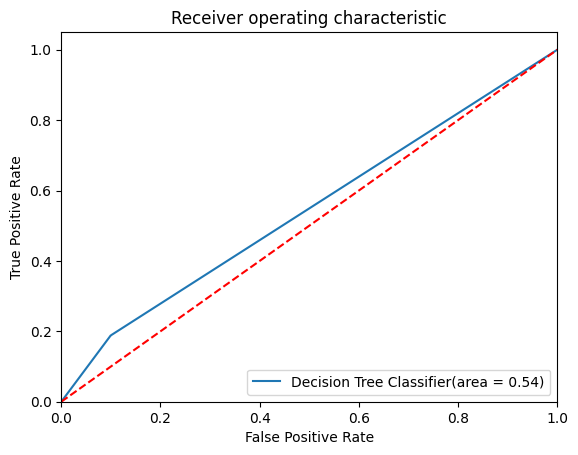

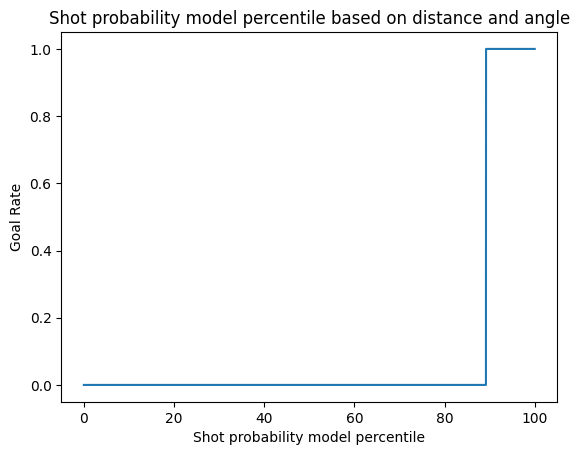

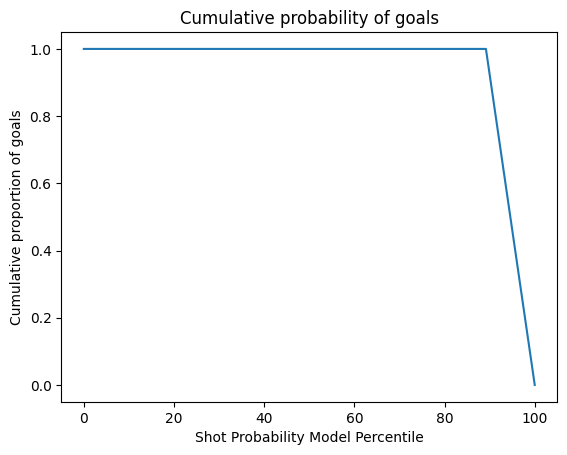

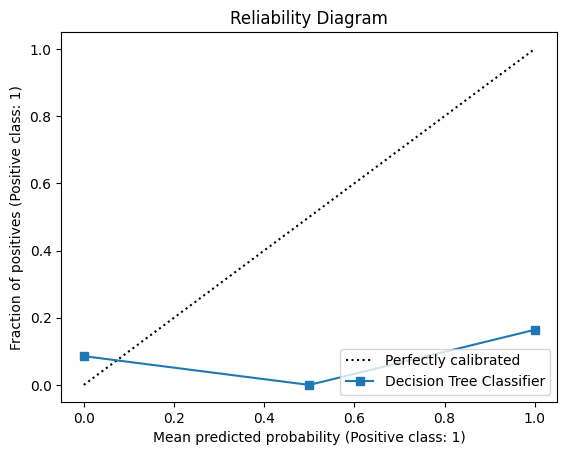

In [16]:
model3, accuracy3, auc3, cm3, report3, precision3, recall3, f1_3 = decision_tree_model(X_train,y_train,X_test,y_test)
plot_roc_curve(model3, X_test, y_test, "Decision Tree Classifier")
shot_probability(model3, X_test)
cumulative_probability(model3, X_test)
calibration_plot(model3, X_test, y_test, "Decision Tree Classifier")

Fitting 3 folds for each of 24 candidates, totalling 72 fits


C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1

Accuracy:  0.9058719675668606
AUC:  0.5
[[55414     0]
 [ 5758     0]]
Precision:  0.0
Recall:  0.0
F1 score:  0.0


C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


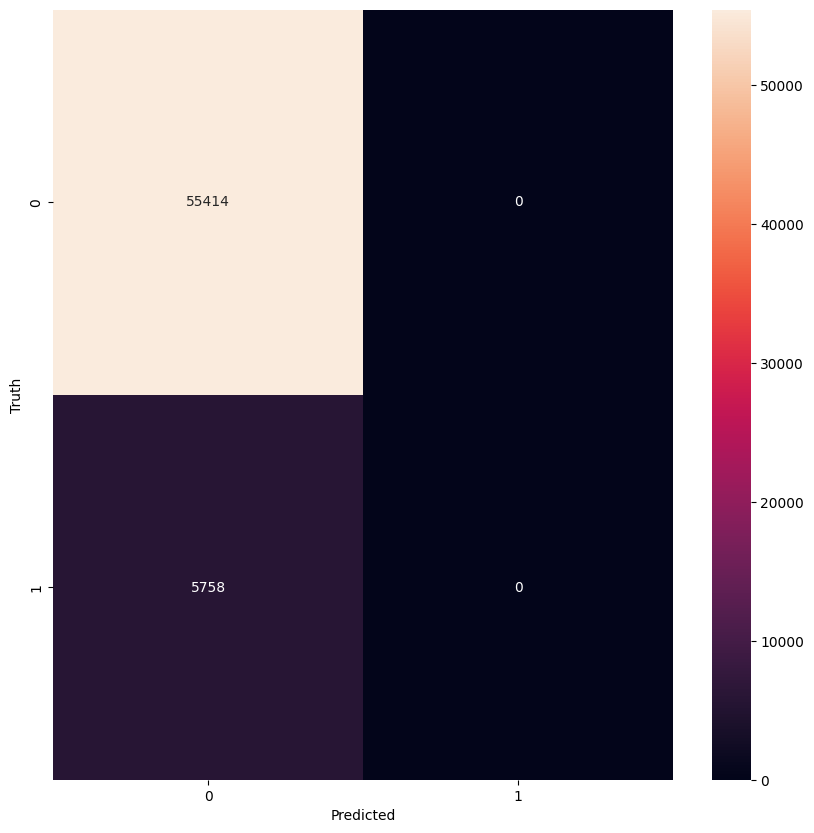

C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     55414
           1       0.00      0.00      0.00      5758

    accuracy                           0.91     61172
   macro avg       0.45      0.50      0.48     61172
weighted avg       0.82      0.91      0.86     61172



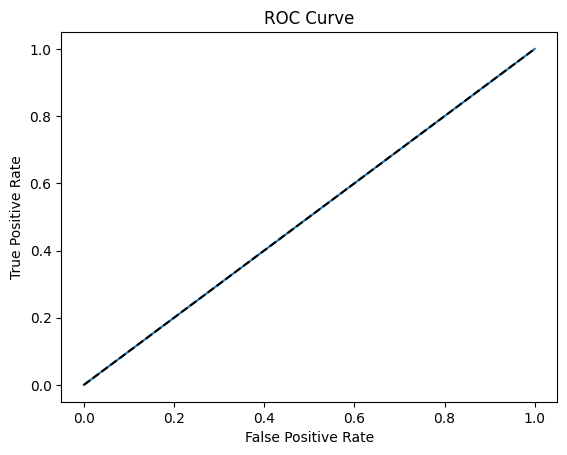

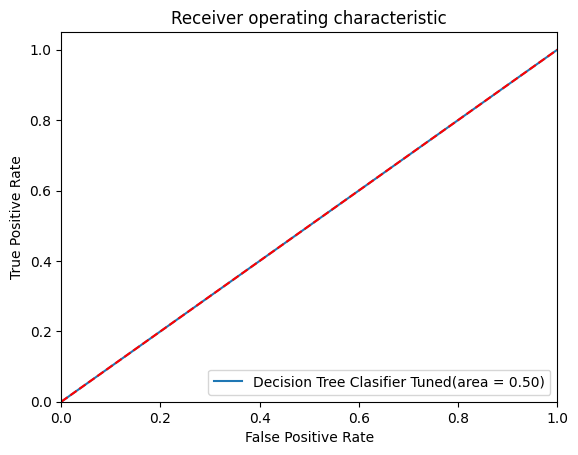

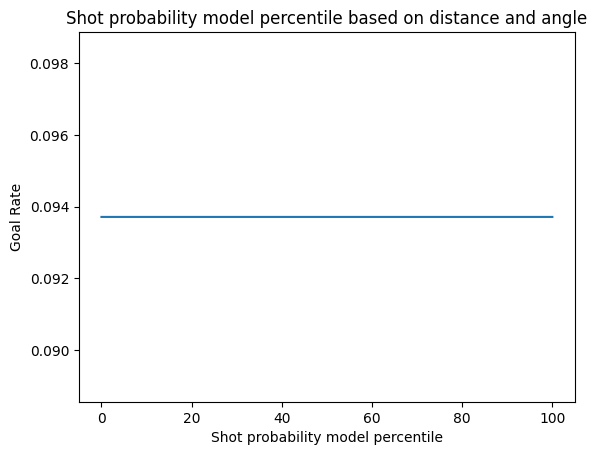

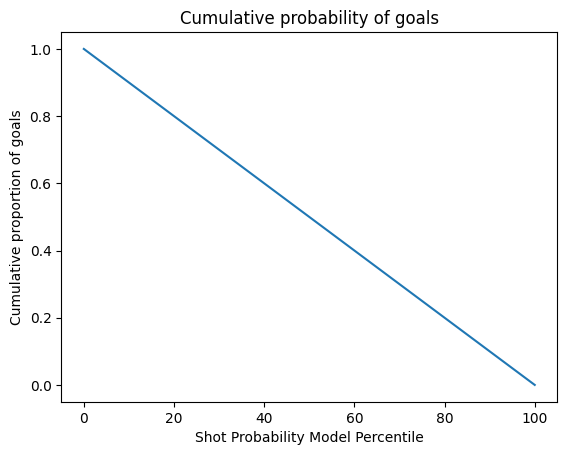

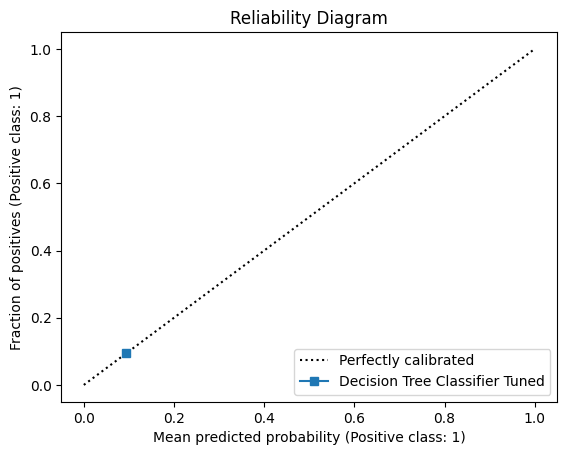

In [17]:
model4, accuracy4, auc4, cm4, report4, precision4, recall4, f1_4 = decision_tree_tuned(X_train,y_train,X_test,y_test)
plot_roc_curve(model4, X_test, y_test, "Decision Tree Clasifier Tuned")
shot_probability(model4, X_test)
cumulative_probability(model4, X_test)
calibration_plot(model4, X_test, y_test, "Decision Tree Classifier Tuned")


In [ ]:
# model5, accuracy5, auc5, cm5, report5, precision5, recall5, f1_5 = knn_classifier(X_train,y_train,X_test,y_test)
# plot_roc_curve(model5, X_test, y_test, "KNN Classifier")
# shot_probability(model5, X_test)
# cumulative_probability(model5, X_test)
# calibration_plot(model5, X_test, y_test, "KNN Classifier")



Accuracy:  0.9058719675668606
AUC:  0.5
[[55414     0]
 [ 5758     0]]
Precision:  0.0
Recall:  0.0
F1 score:  0.0


C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


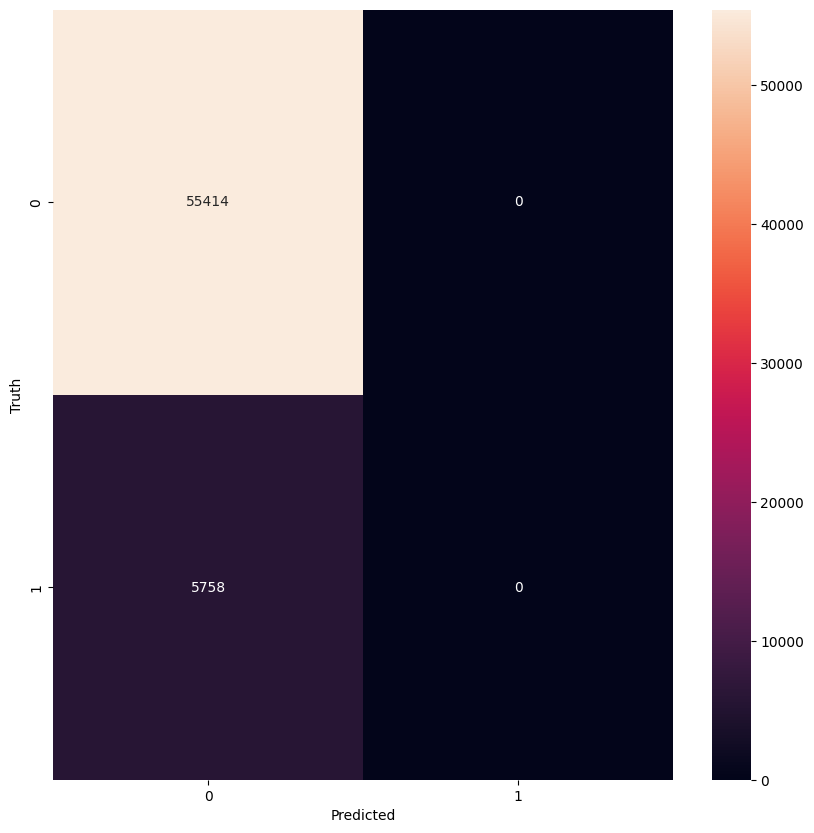

C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     55414
           1       0.00      0.00      0.00      5758

    accuracy                           0.91     61172
   macro avg       0.45      0.50      0.48     61172
weighted avg       0.82      0.91      0.86     61172



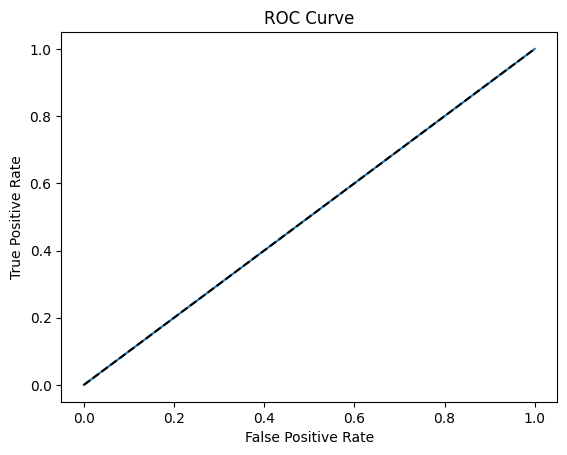

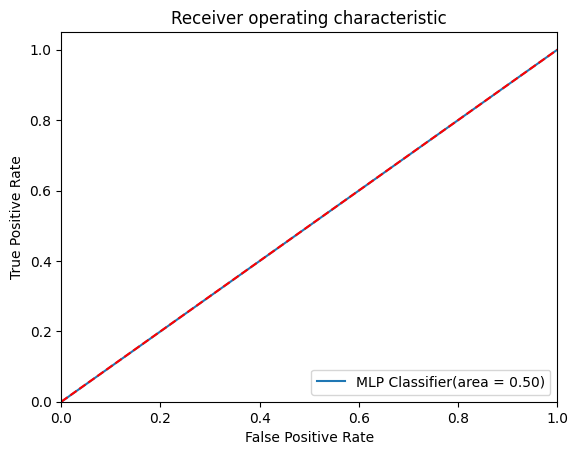

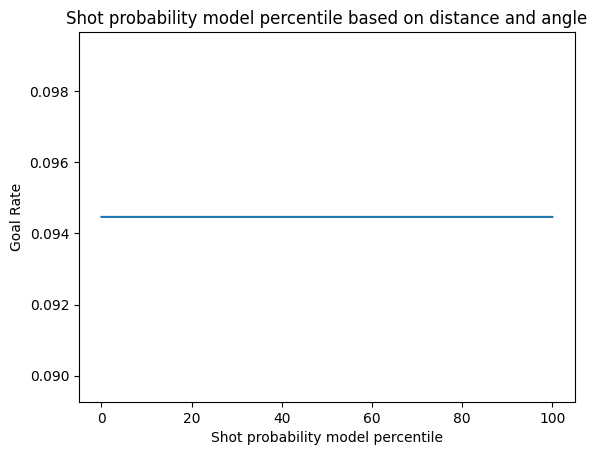

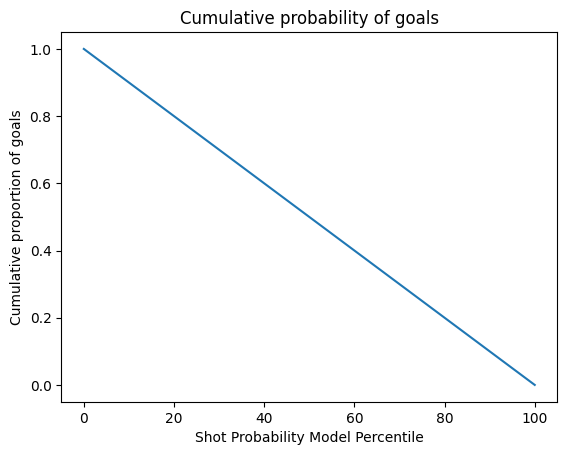

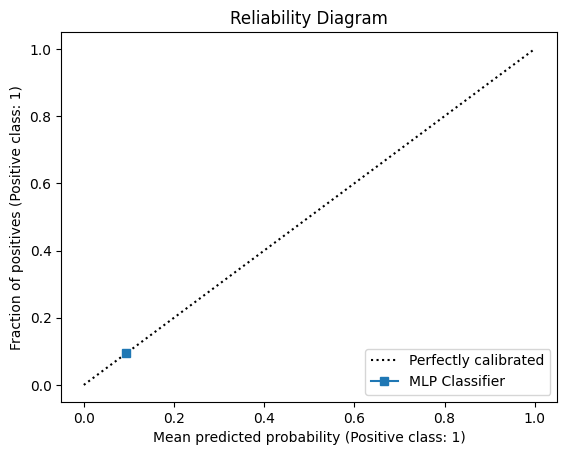

In [18]:
model6, accuracy6, auc6, cm6, report6, precision6, recall6, f1_6 = mlp_classifier(X_train, y_train, X_test, y_test)
plot_roc_curve(model6, X_test, y_test, "MLP Classifier")
shot_probability(model6, X_test)
cumulative_probability(model6, X_test)
calibration_plot(model6, X_test, y_test, "MLP Classifier")

AUC:  0.5
[[55414     0]
 [ 5758     0]]
Precision:  0.0
Recall:  0.0
F1 score:  0.0


C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


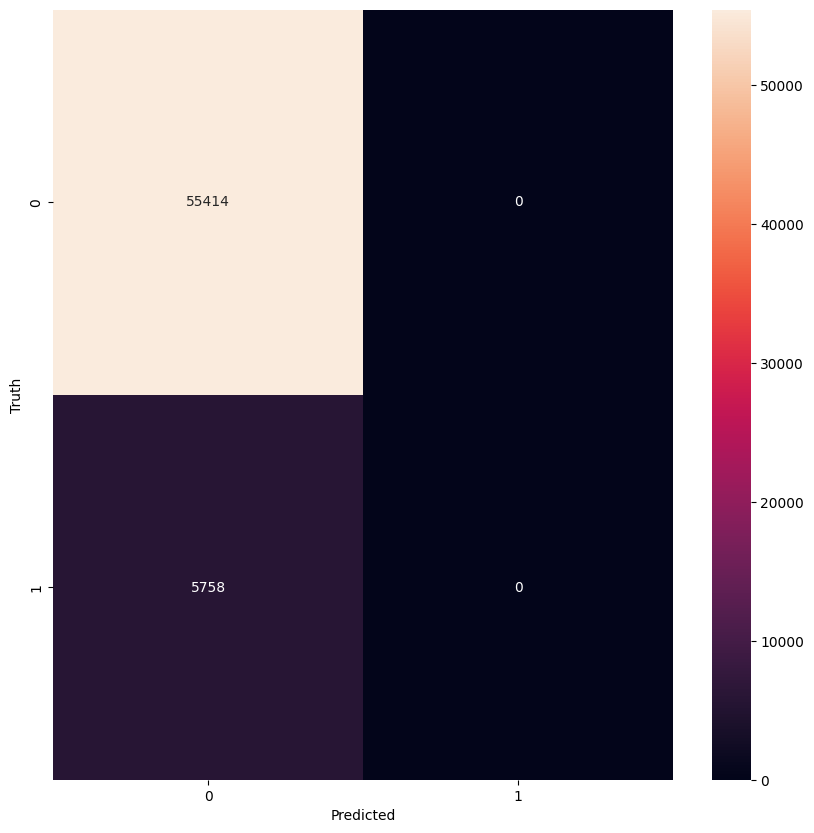

C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     55414
           1       0.00      0.00      0.00      5758

    accuracy                           0.91     61172
   macro avg       0.45      0.50      0.48     61172
weighted avg       0.82      0.91      0.86     61172



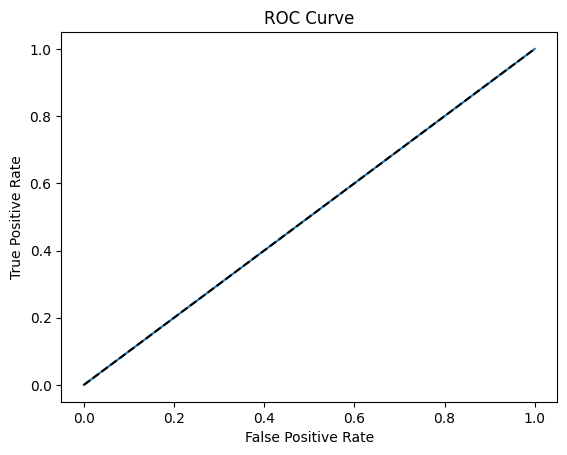

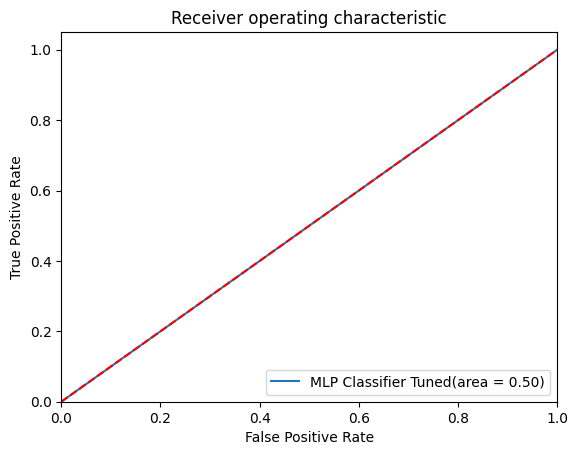

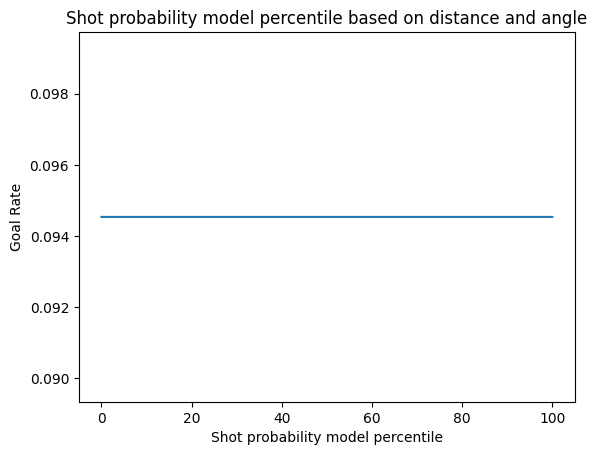

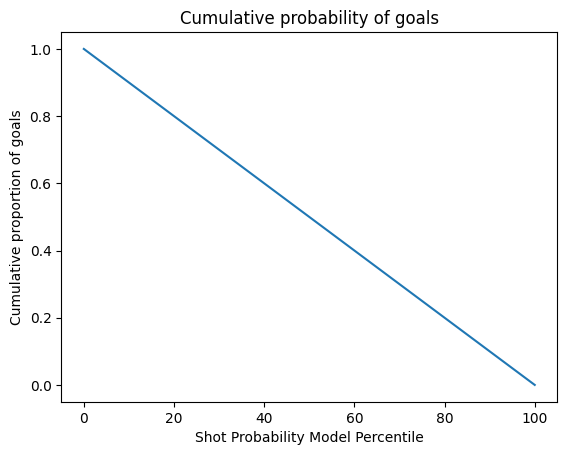

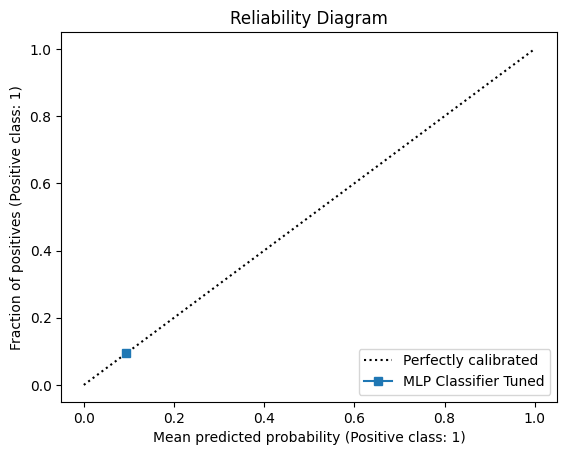

In [19]:
model7, accuracy7, auc7, cm7, report7, precision7, recall7, f1_7 = mlp_classifier_tuned(X_train, y_train, X_test, y_test)
plot_roc_curve(model7, X_test, y_test, "MLP Classifier Tuned")
shot_probability(model7, X_test)
cumulative_probability(model7, X_test)
calibration_plot(model7, X_test, y_test, "MLP Classifier Tuned")


C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptr

AUC:  0.5
[[55414     0]
 [ 5758     0]]
Precision:  0.0
Recall:  0.0
F1 score:  0.0


C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


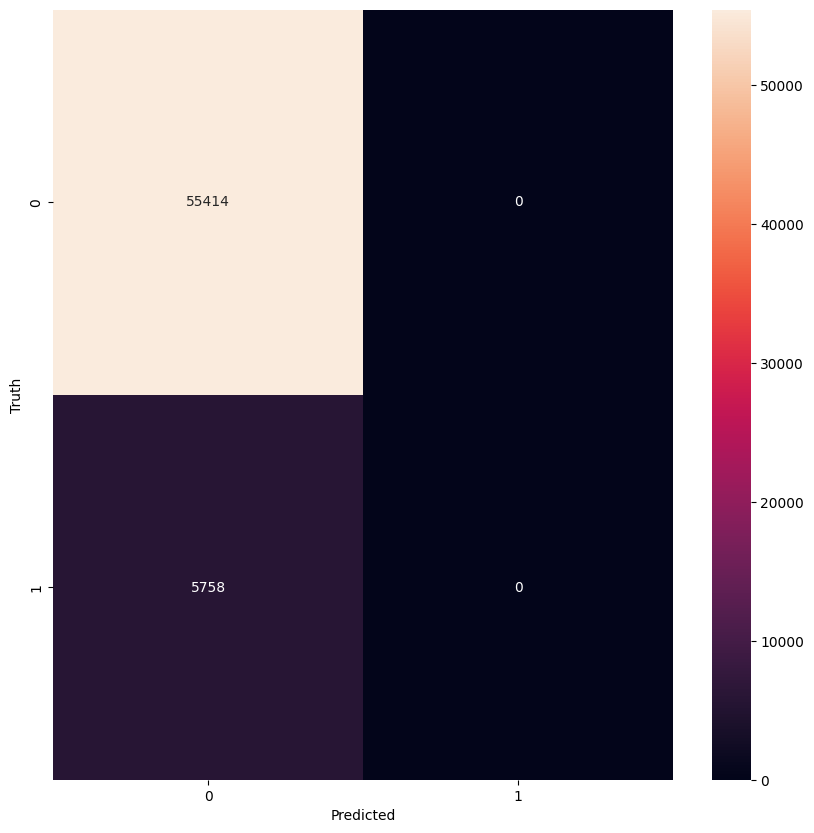

C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     55414
           1       0.00      0.00      0.00      5758

    accuracy                           0.91     61172
   macro avg       0.45      0.50      0.48     61172
weighted avg       0.82      0.91      0.86     61172



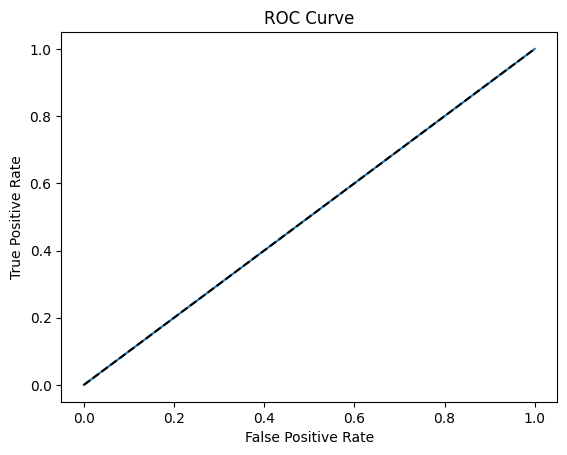

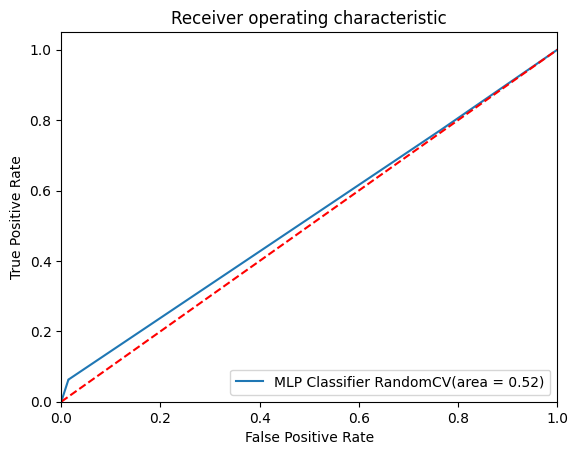

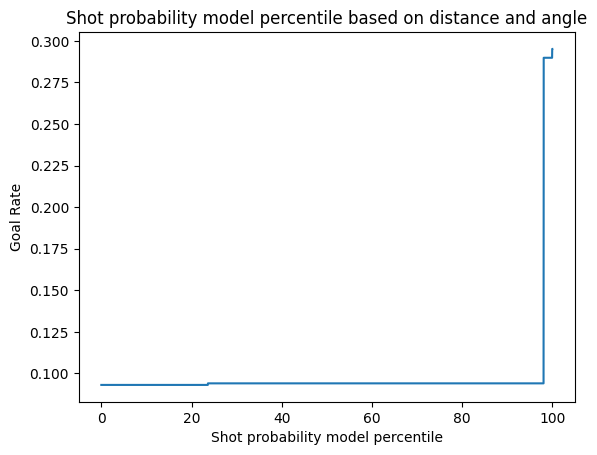

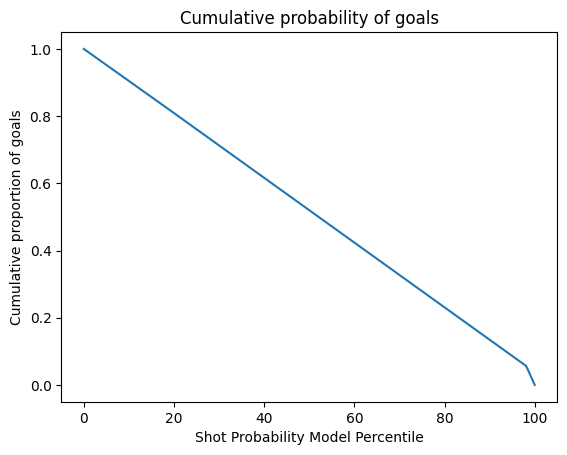

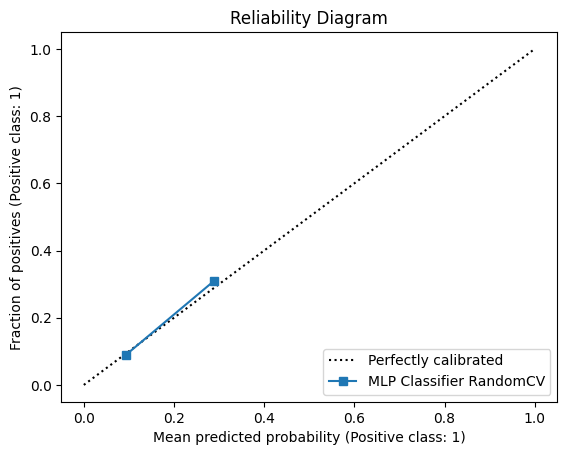

In [20]:
model8, accuracy8, auc8, cm8, report8, precision8, recall8, f1_8 = mlp_classifier_randCV(X_train, y_train, X_test, y_test)
plot_roc_curve(model8, X_test, y_test, "MLP Classifier RandomCV")
shot_probability(model8, X_test)
cumulative_probability(model8, X_test)
calibration_plot(model8, X_test, y_test, "MLP Classifier RandomCV")

In [21]:
def plot_roc_auc(y_val,y_val_pred):
    ns_probs = [0 for _ in range(len(y_val))]
    ns_auc = roc_auc_score(y_val, ns_probs)
    lr_auc = roc_auc_score(y_val, y_val_pred)

    print('Baseline: ROC AUC=%.3f' % (ns_auc))
    print('Goal Prob: ROC AUC=%.3f' % (lr_auc))

    ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_val, y_val_pred)

    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Goal Prob')

    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')

    pyplot.legend()

    pyplot.show()


def percentile(y_pred,y_val):
    df = pd.DataFrame()
    df['pred_prob'] = y_pred
    df['y_true'] = np.array(y_val)
    percentile = [[np.percentile(df['pred_prob'], i), np.percentile(df['pred_prob'], i+5)] for i in range(0,100,5)]
    return df, percentile


def goal_rate(df, percentile):
    goal_rate = []
    for i in range(0, len(percentile)):
        goals = len(df[(df['pred_prob']>percentile[i][0])&(df['pred_prob']<=percentile[i][1])&(df['y_true']==1)])
        no_goals = len(df[(df['pred_prob']>percentile[i][0])&(df['pred_prob']<=percentile[i][1])&(df['y_true']==0)])
        if goals==0:
            goal_rate.append(0)
        else:
            goal_rate.append((goals*100)/(goals+no_goals))
    return goal_rate


def cumulative_proportion(df, percentile):
    total_goal = len(df[df['y_true']==1])
    cum_prop = []
    for i in range(0, len(percentile)-1):
        goals = len(df[(df['pred_prob']>=percentile[i][0]) & (df['y_true']==1)])
        cum_prop.append(goals*100/total_goal)
    cum_prop.append(0)
    return cum_prop

In [22]:
def generate_plots(y_val, y_val_pred1, y_val_pred2, y_val_pred3, y_val_pred4, y_val_pred6, y_val_pred7, y_val_pred8, shot_prob_percentile, goal_rate1, goal_rate2, goal_rate3, goal_rate4, goal_rate6, goal_rate7, goal_rate8, cum_prop1, cum_prop2, cum_prop3, cum_prop4, cum_prop6, cum_prop7, cum_prop8):
    sns.set(rc={'figure.figsize':(15,5)})
    
    fpr1, tpr1, _ = metrics.roc_curve(y_val, y_val_pred1)
    auc1 = metrics.roc_auc_score(y_val, y_val_pred1)
    plt.plot(fpr1,tpr1,label="random forest, auc="+str(auc1))
    
    fpr2, tpr2, _ = metrics.roc_curve(y_val, y_val_pred2)
    auc2 = metrics.roc_auc_score(y_val, y_val_pred2)
    plt.plot(fpr2,tpr2,label="random forest tuned, auc="+str(auc2))
    
    fpr3, tpr3, _ = metrics.roc_curve(y_val, y_val_pred3)
    auc3 = metrics.roc_auc_score(y_val, y_val_pred3)
    plt.plot(fpr3,tpr3,label="decision tree, auc="+str(auc3))
    
    fpr4, tpr4, _ = metrics.roc_curve(y_val, y_val_pred4)
    auc4 = metrics.roc_auc_score(y_val, y_val_pred4)
    plt.plot(fpr4,tpr4,label="decision tree tuned, auc="+str(auc4))
    
    fpr6, tpr6, _ = metrics.roc_curve(y_val, y_val_pred6)
    auc6 = metrics.roc_auc_score(y_val, y_val_pred6)
    plt.plot(fpr6,tpr6,label="mlp, auc="+str(auc6))
    
    fpr7, tpr7, _ = metrics.roc_curve(y_val, y_val_pred7)
    auc7 = metrics.roc_auc_score(y_val, y_val_pred7)
    plt.plot(fpr7,tpr7,label="mlp tuned, auc="+str(auc7))
    
    fpr8, tpr8, _ = metrics.roc_curve(y_val, y_val_pred8)
    auc8 = metrics.roc_auc_score(y_val, y_val_pred8)
    plt.plot(fpr8,tpr8,label="mlp randomCV, auc="+str(auc8))

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=50)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive rate', fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("ROC curve and AUC metric",fontsize=14)
    plt.show()

    sns.set(rc={'figure.figsize':(15,5)})
    plt.plot(shot_prob_percentile,goal_rate1 , label="random forest")
    plt.plot(shot_prob_percentile,goal_rate2, label="random forest tuned")
    plt.plot(shot_prob_percentile,goal_rate3, label="decision tree")
    plt.plot(shot_prob_percentile,goal_rate4, label="decision tree tuned")
    plt.plot(shot_prob_percentile,goal_rate6, label="mlp")
    plt.plot(shot_prob_percentile,goal_rate7, label="mlp tuned")
    plt.plot(shot_prob_percentile,goal_rate8, label="mlp randomCV")
    
    plt.xlim(max(shot_prob_percentile), min(shot_prob_percentile))
    plt.ylim(0, 100)
    plt.xlabel('shot probability model percentile', fontsize=14)
    plt.ylabel('# of Goal/(# of Goal+# of No Goal)', fontsize=14)
    plt.title("Goal Rate",fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    sns.set(rc={'figure.figsize':(15,5)})
    plt.plot(shot_prob_percentile, cum_prop1, label="random forest")
    plt.plot(shot_prob_percentile, cum_prop2, label="random forest tuned")
    plt.plot(shot_prob_percentile, cum_prop3, label="decision tree")
    plt.plot(shot_prob_percentile, cum_prop4, label="decision tree tuned")
    plt.plot(shot_prob_percentile, cum_prop6, label="mlp")
    plt.plot(shot_prob_percentile, cum_prop7, label="mlp tuned")
    plt.plot(shot_prob_percentile, cum_prop8, label="mlp randomCV")
    plt.xlim(max(shot_prob_percentile), min(shot_prob_percentile))
    plt.ylim(0, 100)
    plt.xlabel('shot probability model percentile', fontsize=14)
    plt.ylabel('cumulative proportion', fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Cumulative % of GOAL",fontsize=14)
    plt.show()

    clf_list = [(y_val_pred1,'RF'),(y_val_pred2,'RF Tuned'),(y_val_pred3,'DT'),(y_val_pred4,"DT Tuned"),(y_val_pred6,"MLP"),(y_val_pred7,"MLP Tuned"),(y_val_pred8,"MLP RandomCV")]


    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(4, 2)
    colors = plt.cm.get_cmap("Dark2")

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    calibration_displays = {}
    for i, (clf, name) in enumerate(clf_list):
        display = CalibrationDisplay.from_predictions(

            y_val,
            clf,
            name=name,
            n_bins=40,
            ax=ax_calibration_curve,

        )
        calibration_displays[name] = display


    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Reliability diagram",fontsize=14)

In [23]:
shot_prob_percentile = [i for i in range(0,100,5)]

y_pred1 = model1.predict(X_test)
y_val_pred1 = model1.predict_proba(X_test)[::,1]
df1, percentile1 = percentile(y_val_pred1,y_test)
goal_rate1 = goal_rate(df1, percentile1)
cum_prop1 = cumulative_proportion(df1, percentile1)

y_pred2 = model2.predict(X_test)
y_val_pred2 = model2.predict_proba(X_test)[::,1]
df2, percentile2 = percentile(y_val_pred2,y_test)
goal_rate2 = goal_rate(df2, percentile2)
cum_prop2 = cumulative_proportion(df2, percentile2)

y_pred3 = model3.predict(X_test)
y_val_pred3 = model3.predict_proba(X_test)[::,1]
df3, percentile3 = percentile(y_val_pred3,y_test)
goal_rate3 = goal_rate(df3, percentile3)
cum_prop3 = cumulative_proportion(df3, percentile1)

y_pred4 = model4.predict(X_test)
y_val_pred4 = model4.predict_proba(X_test)[::,1]
df4, percentile4 = percentile(y_val_pred4,y_test)
goal_rate4 = goal_rate(df4, percentile1)
cum_prop4 = cumulative_proportion(df4, percentile1)

y_pred6 = model6.predict(X_test)
y_val_pred6 = model6.predict_proba(X_test)[::,1]
df6, percentile6 = percentile(y_val_pred6,y_test)
goal_rate6 = goal_rate(df6, percentile6)
cum_prop6 = cumulative_proportion(df6, percentile6)

y_pred7 = model7.predict(X_test)
y_val_pred7 = model7.predict_proba(X_test)[::,1]
df7, percentile7 = percentile(y_val_pred7,y_test)
goal_rate7 = goal_rate(df7, percentile1)
cum_prop7 = cumulative_proportion(df7, percentile1)

y_pred8 = model8.predict(X_test)
y_val_pred8 = model8.predict_proba(X_test)[::,1]
df8, percentile8 = percentile(y_val_pred8,y_test)
goal_rate8 = goal_rate(df8, percentile8)
cum_prop8 = cumulative_proportion(df8, percentile8)


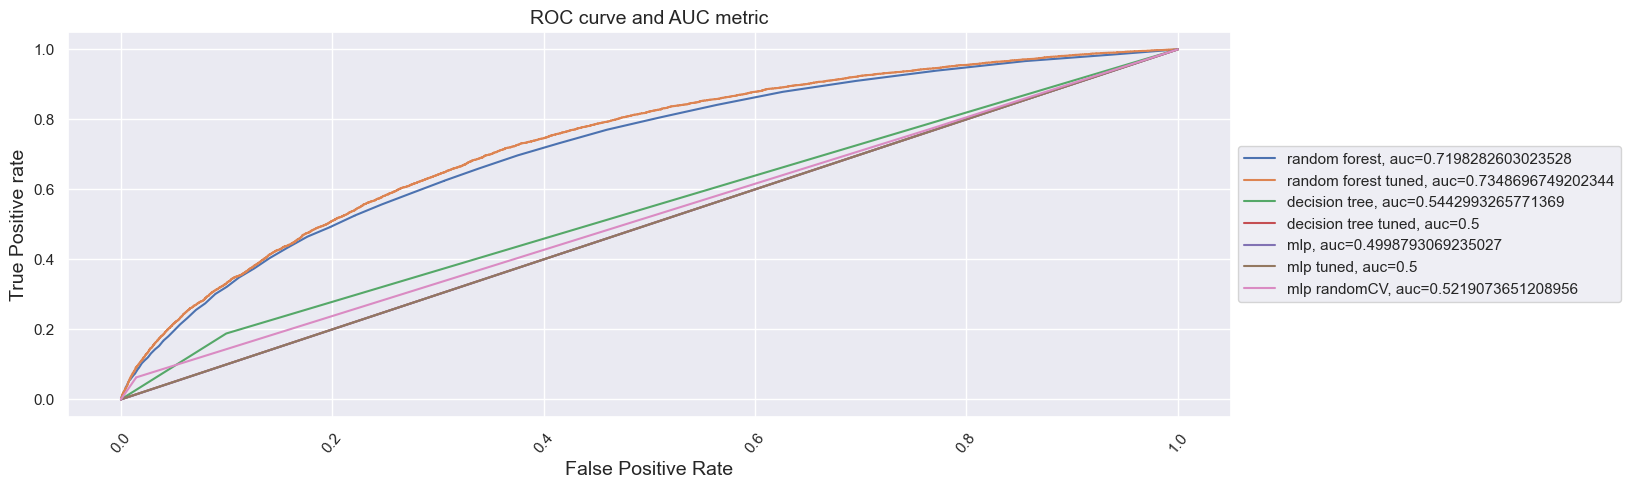

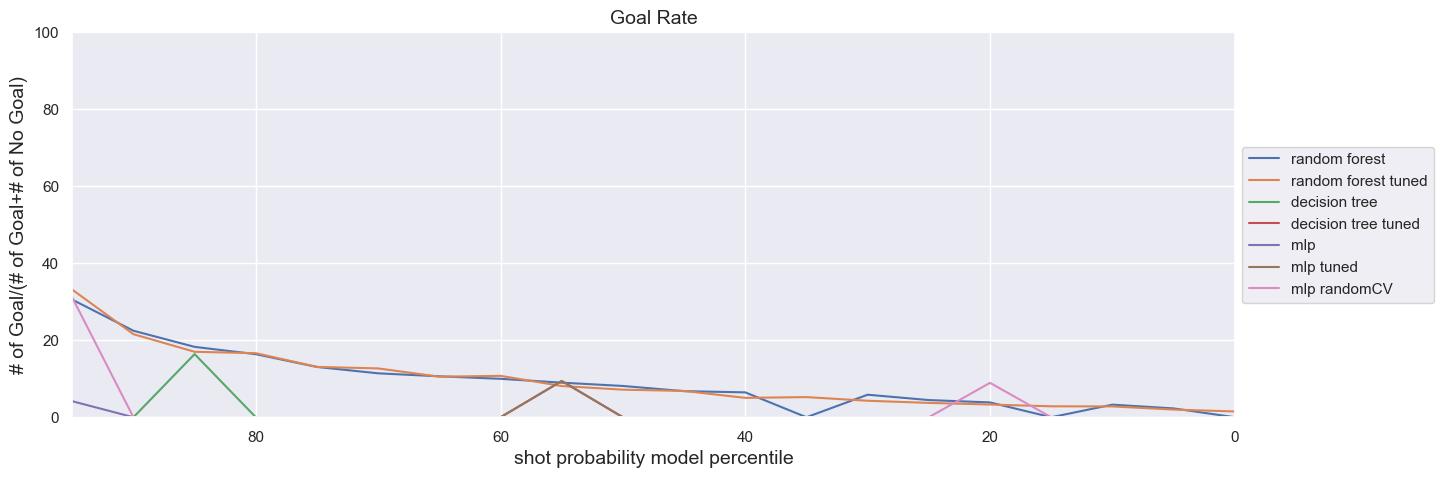

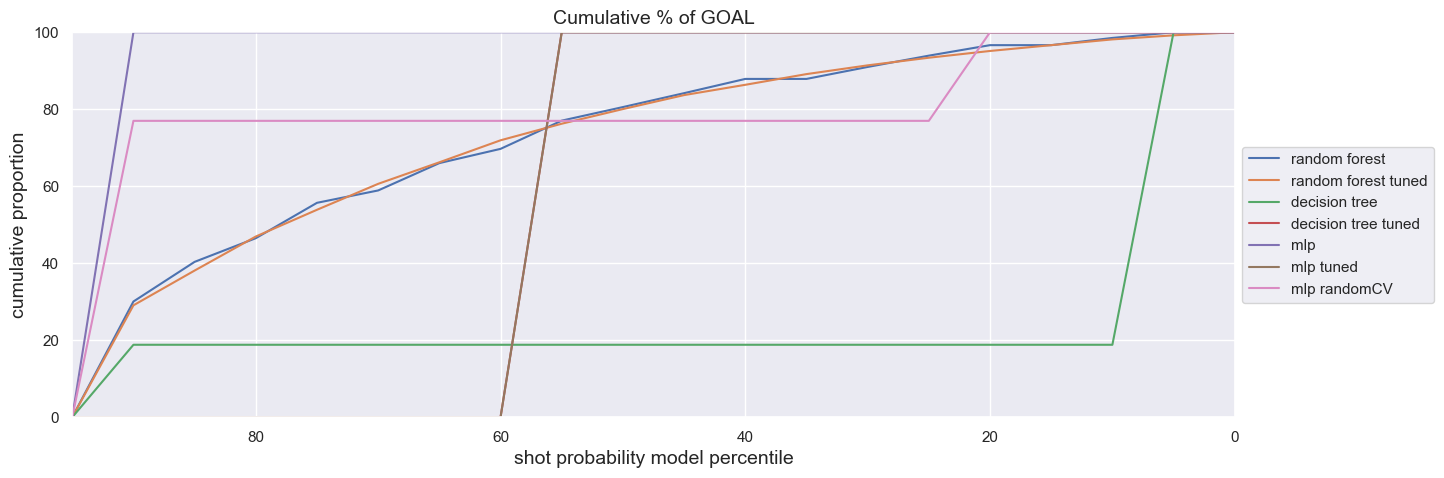

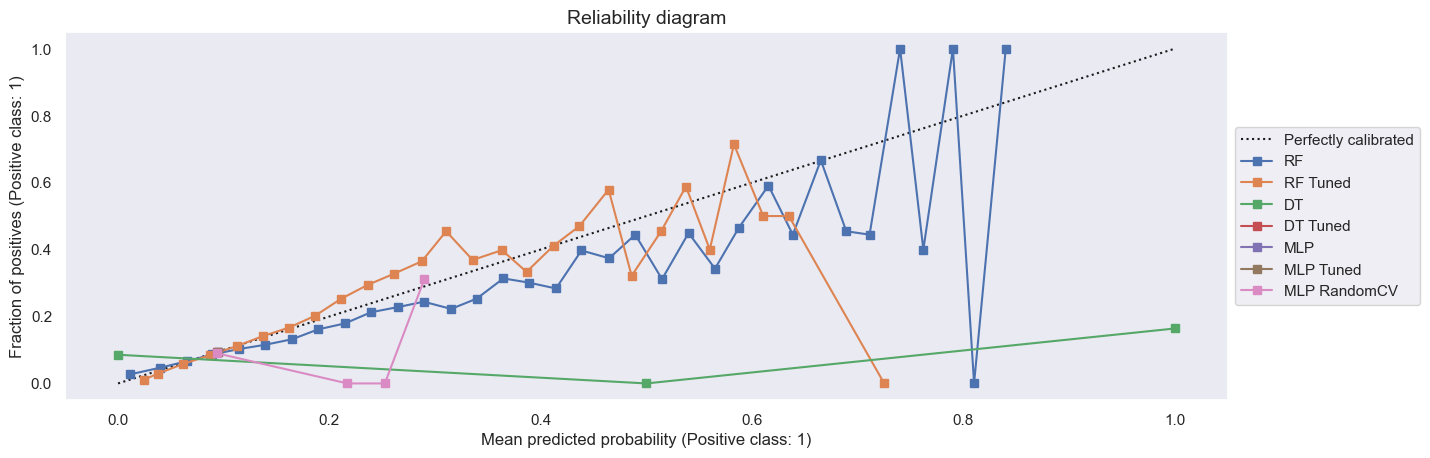

In [24]:
from sklearn import metrics
from matplotlib.gridspec import GridSpec
from sklearn.calibration import calibration_curve, CalibrationDisplay
generate_plots(y_test, y_val_pred1, y_val_pred2, y_val_pred3, y_val_pred4, y_val_pred6, y_val_pred7, y_val_pred8, shot_prob_percentile, goal_rate1, goal_rate2, goal_rate3, goal_rate4, goal_rate6, goal_rate7, goal_rate8, cum_prop1, cum_prop2, cum_prop3, cum_prop4, cum_prop6, cum_prop7, cum_prop8)

In [25]:
def comet_ml(saved_model,df,feat,X_test,y_val,model_name):
    experiment = Experiment(
        api_key=os.environ.get('COMET_API_KEY'),
        project_name='ift-6758-team-8',
        workspace="Rachel98",
    )
    
    model1 = joblib.load(saved_model)
    y_pred_prob = model1.predict_proba(X_test)[::,1]
    y_pred = model1.predict(X_test)
    experiment.log_dataset_hash(df)
    experiment.log_parameters({'model': model_name, 'features': feat})
    experiment.log_metrics({'roc_auc_score': roc_auc_score(y_val, y_pred_prob)})
    experiment.log_metrics({'accuracy_score': accuracy_score(y_val, y_pred)})
    experiment.log_metrics({'precision_score': precision_score(y_val, y_pred)})
    experiment.log_metrics({'recall_score': recall_score(y_val, y_pred)})
    experiment.log_metrics({'f1_score': f1_score(y_val, y_pred)})
    experiment.log_model(model1, saved_model)
    experiment.end()
    
joblib.dump(model1, 'model1.joblib')
comet_ml('model1.joblib',df,"All",X_test,y_test,"Random Forest")

joblib.dump(model2, 'model2.joblib')
comet_ml('model2.joblib',df,"All",X_test,y_test,"Random Forest Tuned")

joblib.dump(model3, 'model3.joblib')
comet_ml('model3.joblib',df,"All",X_test,y_test,"Decision Tree Classifier")

joblib.dump(model4, 'model4.joblib')
comet_ml('model4.joblib',df,"All",X_test,y_test,"Decision Tree Classifier Tuned")

joblib.dump(model6, 'model6.joblib')
comet_ml('model6.joblib',df,"All",X_test,y_test,"MLP Classifier")

joblib.dump(model7, 'model7.joblib')
comet_ml('model7.joblib',df,"All",X_test,y_test,"MLP Classifier Tuned")

joblib.dump(model8, 'model8.joblib')
comet_ml('model8.joblib',df,"All",X_test,y_test,"MLP Classifier RandomCV")

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, keras, tensorflow, tensorboard. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/rachel98/ift-6758-team-8/75c1beaccc0d43e3bcb910ec5e723a30

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/rachel98/ift-6758-team-8/75c1beaccc0d43e3bcb910ec5e723a30
COMET INFO:   Metrics:
COMET INFO:     accuracy_score  : 0.9052344209769175
COMET INFO:     f1_score        : 0.042925540696714545
COME